In [1]:
from matplotlib.pylab import imshow
%matplotlib inline

from pylab import rcParams

import numpy as np
import scipy as sp
import PIL

## Exercise 4.2: Local Feature Detection

In [2]:
from scipy.ndimage.filters import gaussian_filter as gf

In [3]:
# Difference of Gaussian filter
def dog(img, devs):
    return gf(img, devs[0]) - gf(img, devs[1])

In [4]:
# Load the image and convert to floats
# NB: Sometimes image pixel values are stored as unsigned integers which can cause weird results in this exercise.
im = PIL.Image.open('04-material/blobs.jpg').convert('L')
sp_img = sp.misc.fromimage(im).astype('float64')

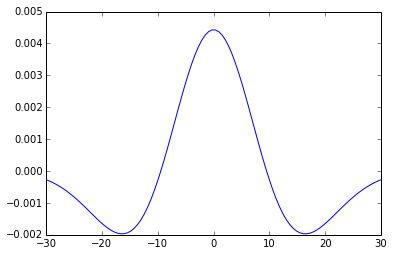

In [5]:
# This is how the DOG filter looks like:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu = 0
sigma = [9,10]
x = np.linspace(-30, 30, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma[0]) - mlab.normpdf(x, mu, sigma[1]))

plt.show()

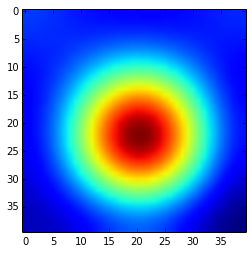

In [6]:
# Applying the DOG filter on a single blob (for illustration)
imshow(dog(sp_img[270:310,150:190], [9,10]))

In [35]:
rcParams['figure.figsize'] = 8, 8

def detect_blobs(img_path, radius):
    img = sp.misc.fromimage(PIL.Image.open(img_path).convert('L')).astype('float64')
    
    dogged = dog(img, [radius-.5, radius+.5])
    #imshow(dogged)

    # Apply a maximum filter to extract the local maxima.
    # Additionally, we request the candidate coordinates to have pixel values above some threshold in the original image
    # and the DOG filter result to exceed another threshold.
    spots = ((dogged == sp.ndimage.filters.maximum_filter(dogged, radius)) & (img>np.mean(img))
             & (dogged>np.amax(dogged)*.15))
    # 'spots' is now a binary image with 1s where we suspect the center of a blob

    # Since it might happen that we have small areas of 1s in blob centers,
    # we count the connected components to get the number of blobs
    labeled, nr_objects = sp.ndimage.label(spots > .5) # count connected components
    print 'number of blobs:',nr_objects
    
    # Visualizing the results:
    # red channel is used for displaying detected blob centers
    # blue channel is used to show original image
    imshow(np.array([(gf(labeled.astype("float64"),1)>0)*255,
                 np.zeros_like(img),img]).transpose([1,2,0]).astype("uint8"))

number of blobs: 19


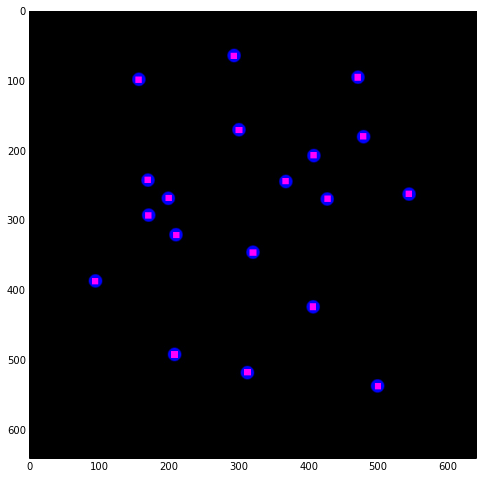

In [36]:
detect_blobs('04-material/blobs.jpg', 9.5)

number of blobs: 66


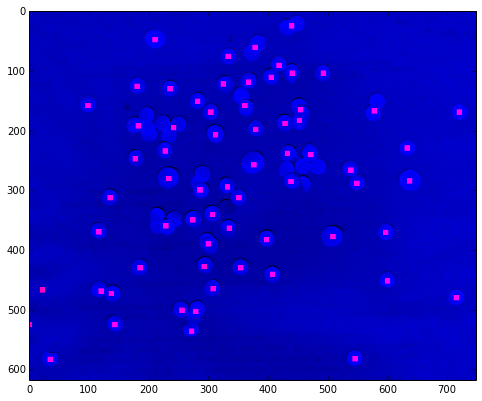

In [37]:
detect_blobs('04-material/cells1.jpg', 12)

number of blobs: 56


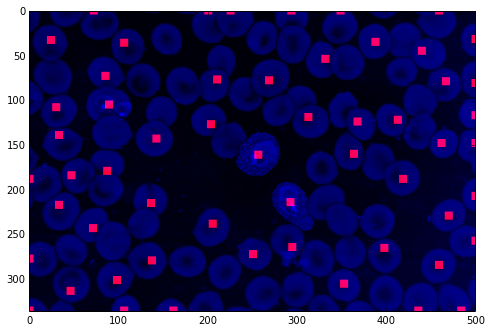

In [44]:
detect_blobs('04-material/cells2.jpg', 17)
# NB: Here you can actually get better results if you specify another radius.

## Exercise 4.3: Vector Quantization

Useful python stuff for this exercise:
- .reshape
- ? (to call the manual in jupyter notebooks)

In [16]:
from sklearn.cluster import KMeans
from scipy.ndimage import imread
from numpy import histogram

In [17]:
# This is how you can read the manual of scipy.cluster.vq:
#import scipy
#from scipy.cluster import vq
#vq?

Let's define the quantization functions and performing the experiments.
(Feel free to play around with different numbers of clusters or histogram bins.)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


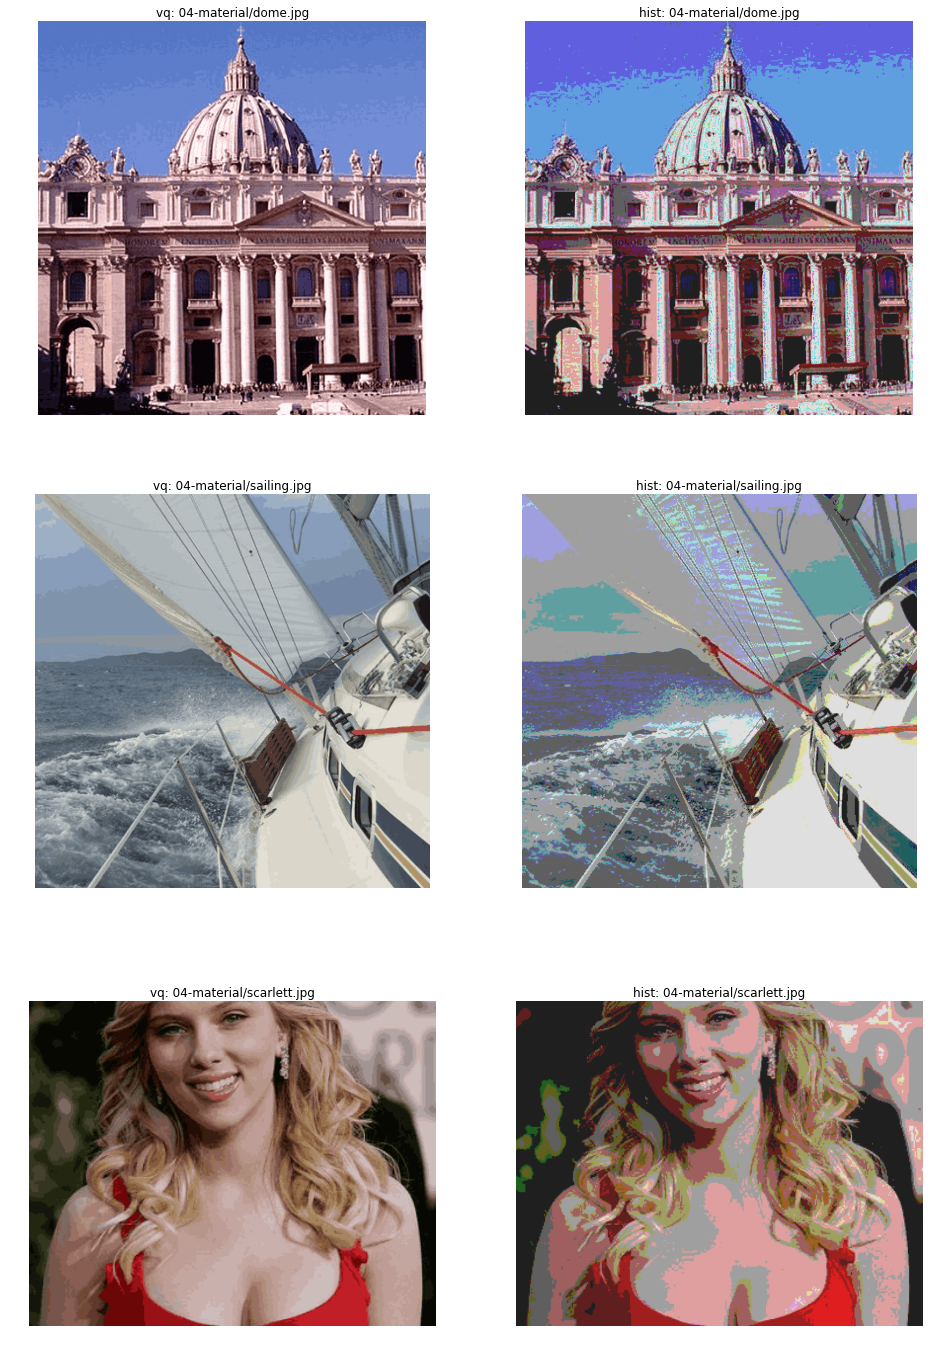

In [18]:
import matplotlib.pylab as plt


def vq_imshow(img_path, n_clusters=32):
    img = imread(img_path)

    rgb_values = img.reshape((-1,3))

    km = KMeans(n_clusters=n_clusters)
    km.fit(rgb_values)

    # use kmeans to convert the image
    converted_img = km.predict(rgb_values)

    # reconstruct the image
    reco_img = np.array(map(lambda cluster_id: km.cluster_centers_[cluster_id], converted_img)).astype('uint8').reshape(img.shape)

    plt.title('vq: %s'%img_path)
    plt.axis('off')
    imshow(reco_img)
    
def hist_imshow(img_path, bins=4):
    img = imread(img_path)
    
    hist =histogram(range(256), bins=bins)[1] #[0, 64, 128, 192, 256]
    bin_index = lambda x: np.argmin(x >= hist) - 1
    
    hist_img = map(bin_index, img.reshape(-1))
    
    bin_value = lambda index: (hist[index+1]+hist[index])*1./2
    
    plt.title('hist: %s'%img_path)
    plt.axis('off')
    imshow(np.array(map(bin_value,hist_img)).astype('uint8').reshape(img.shape))
    
    
rcParams['figure.figsize'] = 16, 24

plt.subplot(3,2,1)
vq_imshow('04-material/dome.jpg')

plt.subplot(3,2,2)
hist_imshow('04-material/dome.jpg')

plt.subplot(3,2,3)
vq_imshow('04-material/sailing.jpg')

plt.subplot(3,2,4)
hist_imshow('04-material/sailing.jpg')

plt.subplot(3,2,5)
vq_imshow('04-material/scarlett.jpg')

plt.subplot(3,2,6)
hist_imshow('04-material/scarlett.jpg')

### Some Results

Observations:
- Quantization based on clustering gives much nicer results but generally takes longer to compute.
- Vector quantization is faster if you use less cluster centers.

Some ideas for measuring quality of color quantization:
- Use any distance measure on $\mathbb{R}^{h\cdot w}$ to measure the distance between original and reconstructed image. (E.g. Euclidean distance measure or more general measures based on a p-norm are reasonable.)
- You could also take into account amount of compression and computation time.
- How exactly you would design this function is highly dependent on the whole setting (including the reason why you are using the compression).